# **Please don't forget to upvote! 😃**

#### **You will need to create Polygon masks in order to use this code and train the model witout error!**
#### **For this you can use this notebook to create COCO split data:**
- https://www.kaggle.com/mistag/sartorius-create-coco-annotations/notebook

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' 

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_7r75unp
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_7r75unp
  Resolved https://github.com/facebookresearch/detectron2.git to commit 085fda47bc49f2cdd9c05a895580b2b31fcdb6c3
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 106 kB 1.2 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 49 kB 2.0 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 1.5 MB/s            
     |████████████████████████████████| 145 kB 2.5 MB/s            
     |████████████████████████████████| 130 kB 3.6 MB/s            
     |████████████████████████████████| 112 kB 4.0 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86

In [2]:
!git clone "https://github.com/MarkPotanin/copy_paste_aug_detectron2"
!cp -r ./copy_paste_aug_detectron2/* ./

Cloning into 'copy_paste_aug_detectron2'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 2.71 MiB | 4.61 MiB/s, done.


# **Imports**

In [3]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore')


from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<_Logger detectron2 (DEBUG)>

In [4]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

In [5]:
Data_Resister_training="sartorius_Cell_train";
Data_Resister_valid="sartorius_Cell_valid";
from detectron2.data.datasets import register_coco_instances
dataDir=Path('../input/sartorius-cell-instance-segmentation/')

DatasetCatalog.clear()
MetadataCatalog.clear()

register_coco_instances(Data_Resister_training,{}, '../input/5foldcleaned/coco_cell_train_fold5_polygon.json', dataDir)
register_coco_instances(Data_Resister_valid,{}, '../input/5foldcleaned/coco_cell_valid_fold5_polygon.json', dataDir) 


metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[12/21 15:32:49 d2.data.datasets.coco]: Loading ../input/5foldcleaned/coco_cell_train_fold5_polygon.json takes 2.85 seconds.
[12/21 15:32:49 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/5foldcleaned/coco_cell_train_fold5_polygon.json
[12/21 15:32:51 d2.data.datasets.coco]: Loading ../input/5foldcleaned/coco_cell_valid_fold5_polygon.json takes 1.05 seconds.
[12/21 15:32:51 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/5foldcleaned/coco_cell_valid_fold5_polygon.json


# **Original Data**

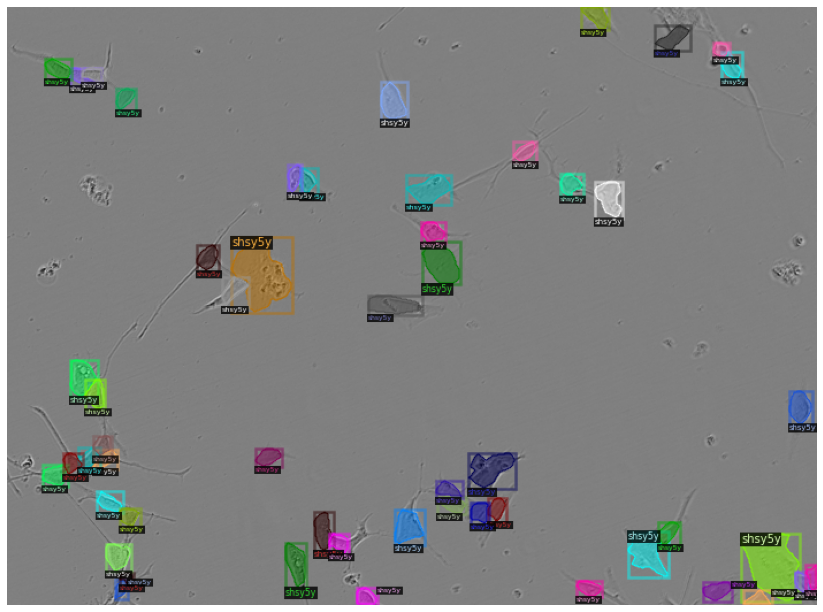

In [6]:
fig, ax = plt.subplots(figsize=(18,11))
d=dataset_valid[5] 
img = cv2.imread(d["file_name"])

v = Visualizer(img[:, :, ::-1],
                metadata=metadata, 
                scale=1,
                instance_mode=ColorMode.IMAGE_BW
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

In [7]:
import os
import cv2
from torchvision.datasets import CocoDetection
from copy_paste import copy_paste_class
import torch.utils.data as data
from PIL import Image
import os
import os.path

min_keypoints_per_image = 10

def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

def has_valid_annotation(anno):
    if len(anno) == 0:
        return False
    if _has_only_empty_bbox(anno):
        return False
    if "keypoints" not in anno[0]:
        return True
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True

    return False

@copy_paste_class
class CocoDetectionCP(CocoDetection):
    def __init__(
        self,
        root,
        annFile,
        transforms
    ):
        super(CocoDetectionCP, self).__init__(
            root, annFile, None, None, transforms
        )

        ids = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=[img_id], iscrowd=None)
            anno = self.coco.loadAnns(ann_ids)
            if has_valid_annotation(anno):
                ids.append(img_id)
        self.ids = ids

    def load_example(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        target = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs([img_id])[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        masks = []
        bboxes = []
        for ix, obj in enumerate(target):
            masks.append(self.coco.annToMask(obj))
            bboxes.append(obj['bbox'] + [obj['category_id']] + [ix])

        output = {
            'image': image,
            'masks': masks,
            'bboxes': bboxes
        }
        
        return self.transforms(**output)

# **Create Dataloader with Augemented Images**

In [8]:
transform = A.Compose([
        CopyPaste(blend=True, sigma=1, pct_objects_paste=0.65, p=1.0)
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

data = CocoDetectionCP(
    "../input/sartorius-cell-instance-segmentation", 
    '../input/5foldcleaned/coco_cell_train_fold5_polygon.json', 
    transform
)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!


In [9]:
data

Dataset CocoDetectionCP
    Number of datapoints: 485
    Root location: ../input/sartorius-cell-instance-segmentation
    Compose([
  CopyPaste(always_apply=False, p=1.0, blend=True, sigma=1, pct_objects_paste=0.65, max_paste_objects=None),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.05, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

# **Visualize Example**

### **Same Image - More Data :)**

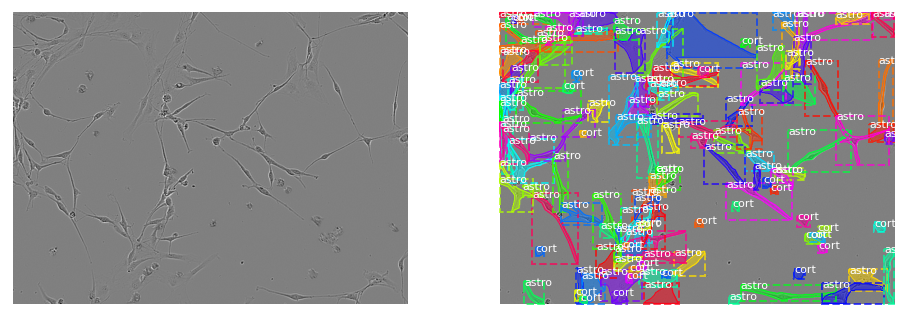

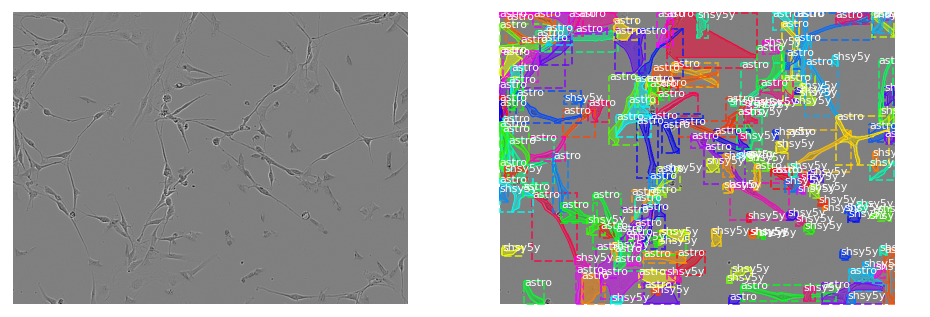

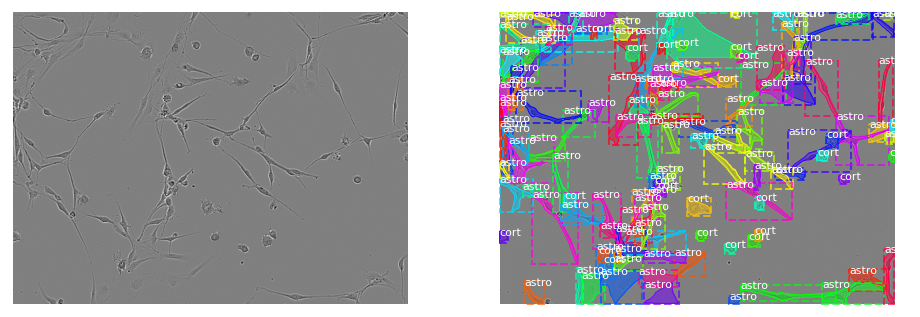

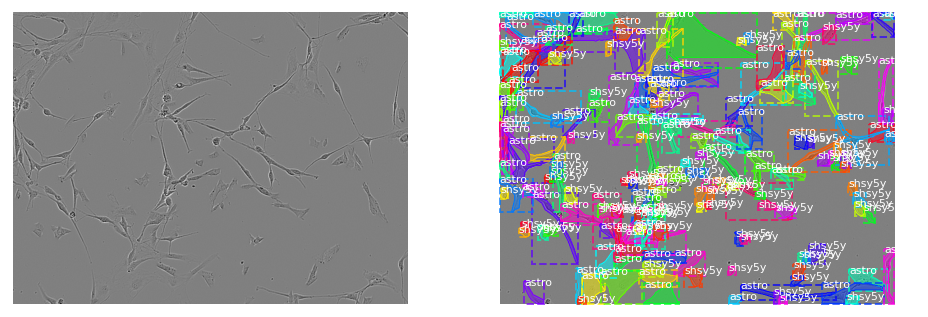

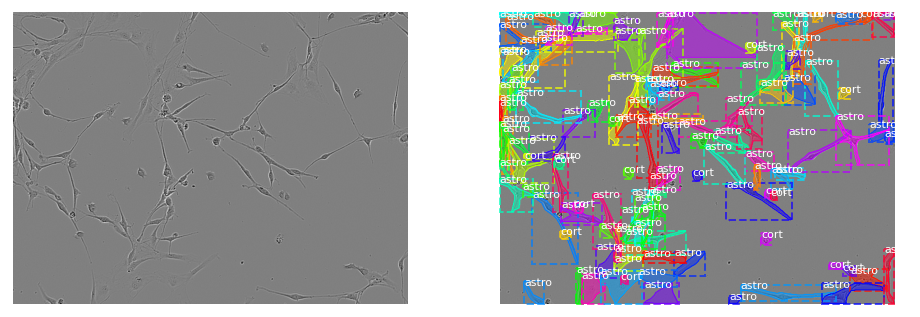

In [10]:
for i in range(5):
    img_data = data[1]

    f, ax = plt.subplots(1, 2, figsize=(16, 16))
    image = img_data['image']
    masks = img_data['masks']
    bboxes = img_data['bboxes']

    empty = np.array([])
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

    if len(bboxes) > 0:
        boxes = np.stack([b[:4] for b in bboxes], axis=0)
        box_classes = np.array([b[-2] for b in bboxes])
        mask_indices = np.array([b[-1] for b in bboxes])
        show_masks = np.stack(masks, axis=-1)[..., mask_indices]
        class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
        display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
    else:
        display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])

# **Define Custom Mapper**

In [11]:
DATA = {i:q for q,i in enumerate(data.ids)}
IDS = list(DATA.keys())
dataset_dicts_train = [i for i in dataset_train if i['image_id'] in IDS]

In [12]:
from pycocotools import mask
from skimage import measure

class MyMapper:
    def __init__(self, cfg, is_train: bool = True):
        self.is_train = is_train

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict) 
        img_id = dataset_dict['image_id']
        
        aug_sample = data[DATA[img_id]]
        image = aug_sample['image']
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        
        bboxes = aug_sample['bboxes']
        box_classes = np.array([b[-2] for b in bboxes])
        boxes = np.stack([b[:4] for b in bboxes], axis=0)
        mask_indices = np.array([b[-1] for b in bboxes])
        masks = aug_sample['masks']
        annos = []
        
        for enum, index in enumerate(mask_indices):
            curr_mask = masks[index]
            _gt_binary_mask = np.asfortranarray(curr_mask)
            encoded_ground_truth = mask.encode(_gt_binary_mask)
            _area = mask.area(encoded_ground_truth)
            _gt_bounding_box = mask.toBbox(encoded_ground_truth)
            contours = measure.find_contours(curr_mask, 0.5)
            
            annotation = {
                "segmentation": [],
                "iscrowd": 0,
                "bbox": _gt_bounding_box.tolist(), 
                "category_id": metadata.thing_dataset_id_to_contiguous_id[box_classes[enum]],
                "bbox_mode": dataset_train[0]['annotations'][0]['bbox_mode'],
            }
            
            for contour in contours:
                contour = np.flip(contour, axis=1)
                segmentation = contour.ravel().tolist()
                annotation["segmentation"].append(segmentation)
            annos.append(annotation)
        
        image_shape = image.shape[:2]
        
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
        return dataset_dict

In [13]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.data import DatasetMapper
from detectron2.modeling import build_model, GeneralizedRCNNWithTTA

def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
        
    return np.mean(prec)


class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

In [14]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=MyMapper(cfg),)
    
#     @classmethod
#     def build_evaluator(cls, cfg, dataset_name, output_folder=None):
#         return COCOEvaluator(dataset_name, cfg, False, output_folder)

# **Training**

In [15]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
# cfg.MODEL.DEVICE = "cpu"

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.INPUT.MASK_FORMAT='polygon'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5


cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.BASE_LR = 0.005 
cfg.SOLVER.MOMENTUM = 0.9


    
cfg.SOLVER.WARMUP_ITERS = 400 
cfg.SOLVER.MAX_ITER = 40000 
cfg.TEST.EVAL_PERIOD = 300
cfg.SOLVER.CHECKPOINT_PERIOD = 300


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) 
trainer = MyTrainer(cfg) 

[12/21 15:33:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
# trainer.resume_or_load(resume=True)
# trainer.train()